In [78]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re, pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer

from xgboost import XGBClassifier

#from model_architecture_and_metrics import *

# Load Data

In [2]:
df = pd.read_csv('./data/sorted_df_14_15.csv', index_col=0)

In [3]:
# #change positions to numbered 1-5
# df.pos[df.pos=='PG'] = 1
# df.pos[df.pos=='SG'] = 2
# df.pos[df.pos=='SF'] = 3
# df.pos[df.pos=='PF'] = 4
# df.pos[df.pos=='C'] = 5

#convert negative touch times to 0
df.touch_time[df.touch_time<0] = 0
#combine all OT periods into one category
df.period = np.where(df.period>4, 5, df.period)

In [4]:
df.defender_name[df.defender_name=='0'] = 'None'

def convert_defender_names(player):
    if player =='None':
        return 'None'
    elif player=='Nene':
        return 'Nene'
    else:
        name = player.split(', ')
        full_name = ' '.join((name[1],name[0]))
        return re.sub(r'([^\s\w]|_)+', '', full_name)
    
df.defender_name = df.defender_name.apply(convert_defender_names)

# Clean up name discrepancies between two dfs
df.defender_name[df.defender_name=='Jose Juan Barea'] = 'JJ Barea'
df.defender_name[df.defender_name=='Tim Hardaway Jr'] = 'Tim Hardaway'
df.defender_name[df.defender_name=='Charles Hayes'] = 'Chuck Hayes'
df.defender_name[df.defender_name=='Glen Rice Jr'] = 'Glen Rice'
df.defender_name[df.defender_name=='Louis Williams'] = 'Lou Williams'

In [5]:
player_ids_df = df[['name','player_id']].rename(columns={'name':'defender_name','player_id':'defender_id'})
player_ids_df = player_ids_df.groupby('defender_name').max()

#create id for no defender (id=0) and append to player_ids_df
none_id = pd.DataFrame(data=[('None',0)],
                       columns=['defender_name','defender_id']).set_index('defender_name')
player_ids_df = pd.concat((player_ids_df,none_id))

df = df.merge(player_ids_df, on='defender_name')

In [6]:
#change dtypes
df[['pos','player_id','team_id','game_event_id','period','action_type','opp_id','defender_id',
    'shot_zone','shot_area']] = df[['pos','player_id','team_id','game_event_id','period','action_type',
                                    'opp_id','defender_id','shot_zone','shot_area']].astype('category')

df.game_date = pd.to_datetime(df.game_date)

In [7]:
#create dummies for shot_zone and shot_area
df = pd.concat([df,pd.get_dummies(df.shot_zone),
                pd.get_dummies(df.shot_area)],axis=1).drop(columns=['shot_zone','shot_area','period'])

In [8]:
df.head()

,name,pos,age,player_id,team_name,team_id,game_date,game_id,game_event_id,season,minutes_remaining,seconds_remaining,shot_made_flag,action_type,shot_type,shot_distance,x,y,dribbles,touch_time,opponent,opp_id,defender_name,defender_distance,shot_clock,lg_avg,htm,vtm,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,defender_id,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R
0,Aaron Gordon,PF,19,203932,Orlando Magic,10,2014-10-28,21400001,164,2014,11,34,1,Jump Shot,2,4,-10,44,4,5.1,New Orleans Pelicans,13,Ryan Anderson,3.9,0.6,0.4011,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,201583,0,0,0,0,1,0,1,0,0
1,Austin Rivers,SG,22,203085,Los Angeles Clippers,29,2015-01-30,21400701,104,2014,1,34,0,Jump Shot,3,26,-225,135,0,0.9,New Orleans Pelicans,13,Ryan Anderson,8.6,7.6,0.3438,NOP,LAC,0,0,0,0,0.3500,0.0714,0.4667,0.5052,0.0,0.2941,0.5,0.2917,0.4167,0.3448,0.3000,0.1111,0.4286,201583,1,0,0,0,0,0,0,0,1
2,Ben Gordon,SG,31,2732,Orlando Magic,10,2014-10-28,21400001,123,2014,2,0,0,Pullup Jump shot,2,10,-78,77,6,5.4,New Orleans Pelicans,13,Ryan Anderson,5.9,18.1,0.3844,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,201583,0,0,0,0,1,0,0,0,1
3,Dewayne Dedmon,C,25,203473,Orlando Magic,10,2015-02-20,21400803,78,2014,2,43,1,Driving Layup Shot,2,2,18,15,0,0.9,New Orleans Pelicans,13,Ryan Anderson,1.2,13.0,0.5999,ORL,NOP,1,0,0,0,1.0000,0.0000,0.0000,0.5970,0.0,0.0000,0.0,0.0000,0.3333,0.4286,0.3333,0.0000,0.0000,201583,0,0,0,0,0,1,1,0,0
4,Elfrid Payton,PG,20,203901,Orlando Magic,10,2015-02-20,21400803,434,2014,4,28,0,Driving Layup Shot,2,1,10,17,4,3.6,New Orleans Pelicans,13,Ryan Anderson,1.0,3.5,0.5999,ORL,NOP,1,1,1,1,0.4545,0.3333,0.3103,0.4978,0.0,0.6667,0.0,0.0909,0.5000,0.3210,0.4000,0.0000,1.0000,201583,0,0,0,0,0,1,1,0,0


### Merge adv defensive stats

In [11]:
stats = pd.read_excel('./data/adv-stats-14-15.xlsx').rename(columns={'Player': 'defender_name',
                                                                     'BLK%':'blk_pct',
                                                                     'DWS':'dws',
                                                                     'DBPM':'dbpm'})
defense_stats = stats.drop(columns=['Rk','Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'TOV%', 'USG%', 'OWS','WS', 'WS/48', 'OBPM', 'BPM', 'VORP'])

defense_stats.defender_name = defense_stats.defender_name.apply(lambda x: re.sub(r'([^\s\w]|_)+', '',x))

defense_stats.defender_name[defense_stats.defender_name=='Nene Hilario'] = 'Nene'
defense_stats.defender_name[defense_stats.defender_name=='Jeffery Taylor'] = 'Jeff Taylor'
defense_stats.defender_name[defense_stats.defender_name== 'Luigi Datome'] = 'Gigi Datome'

In [12]:
#add dummy stats for no defender (id=0) and append to defense_stats
none_stats = pd.DataFrame(data=[('None',0,0,0)],
                       columns=['defender_name','blk_pct','dws','dbpm'])
defense_stats = pd.concat((defense_stats,none_stats)).reset_index(drop=True)


In [13]:
df = df.merge(defense_stats, on='defender_name')
df.head()

,name,pos,age,player_id,team_name,team_id,game_date,game_id,game_event_id,season,minutes_remaining,seconds_remaining,shot_made_flag,action_type,shot_type,shot_distance,x,y,dribbles,touch_time,opponent,opp_id,defender_name,defender_distance,shot_clock,lg_avg,htm,vtm,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,defender_id,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R,blk_pct,dws,dbpm
0,Aaron Gordon,PF,19,203932,Orlando Magic,10,2014-10-28,21400001,164,2014,11,34,1,Jump Shot,2,4,-10,44,4,5.1,New Orleans Pelicans,13,Ryan Anderson,3.9,0.6,0.4011,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,201583,0,0,0,0,1,0,1,0,0,0.9,0.9,-3.1
1,Austin Rivers,SG,22,203085,Los Angeles Clippers,29,2015-01-30,21400701,104,2014,1,34,0,Jump Shot,3,26,-225,135,0,0.9,New Orleans Pelicans,13,Ryan Anderson,8.6,7.6,0.3438,NOP,LAC,0,0,0,0,0.3500,0.0714,0.4667,0.5052,0.0,0.2941,0.5,0.2917,0.4167,0.3448,0.3000,0.1111,0.4286,201583,1,0,0,0,0,0,0,0,1,0.9,0.9,-3.1
2,Ben Gordon,SG,31,2732,Orlando Magic,10,2014-10-28,21400001,123,2014,2,0,0,Pullup Jump shot,2,10,-78,77,6,5.4,New Orleans Pelicans,13,Ryan Anderson,5.9,18.1,0.3844,NOP,ORL,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,201583,0,0,0,0,1,0,0,0,1,0.9,0.9,-3.1
3,Dewayne Dedmon,C,25,203473,Orlando Magic,10,2015-02-20,21400803,78,2014,2,43,1,Driving Layup Shot,2,2,18,15,0,0.9,New Orleans Pelicans,13,Ryan Anderson,1.2,13.0,0.5999,ORL,NOP,1,0,0,0,1.0000,0.0000,0.0000,0.5970,0.0,0.0000,0.0,0.0000,0.3333,0.4286,0.3333,0.0000,0.0000,201583,0,0,0,0,0,1,1,0,0,0.9,0.9,-3.1
4,Elfrid Payton,PG,20,203901,Orlando Magic,10,2015-02-20,21400803,434,2014,4,28,0,Driving Layup Shot,2,1,10,17,4,3.6,New Orleans Pelicans,13,Ryan Anderson,1.0,3.5,0.5999,ORL,NOP,1,1,1,1,0.4545,0.3333,0.3103,0.4978,0.0,0.6667,0.0,0.0909,0.5000,0.3210,0.4000,0.0000,1.0000,201583,0,0,0,0,0,1,1,0,0,0.9,0.9,-3.1


In [136]:
df.to_csv('data/final_df.csv')

In [14]:
# #re-sort columns
# df = df[['name', 'pos', 'age', 'player_id', 'team_name', 'team_id', 'game_date',
#        'game_id', 'game_event_id', 'season', 'period', 'minutes_remaining',
#        'seconds_remaining', 'shot_made_flag', 'action_type', 'shot_type',
#        'shot_distance', 'x', 'y', 'dribbles', 'touch_time', 'shot_clock', 'opponent',
#        'opp_id', 'defender_name','defender_id', 'defender_distance', 'blk_pct','dws','dbpm',
#        'shot_zone', 'shot_area', 'lg_avg', 'htm', 'vtm', 'is_home',
#        'prev_shot_made', 'prev_2_made', 'prev_3_made']]

# Model Architecture and Metrics

#### Model Architecture

In [15]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True):
    start = time.time()
    
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score, fpr, tpr, thresholds

#### Feature Importance

In [16]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")

#### Confusion Matrix

In [17]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['Miss','Make']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#### Metrics Printout

In [18]:
def print_model_metrics(y_pred,y_score):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    true_negative, false_positive, false_negative, true_positive = cm[0,0], cm[0,1], cm[0,1], cm[0,1]

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    #print('Training Set Metrics:')
    print('Accuracy:   {}'.format(round(accuracy,4)))
    print('Precision:  {}'.format(round(precision,4)))
    print('Recall:     {}'.format(round(recall,4)))
    print('F1          {}'.format(round(f1,4)))
    print('AUC:        {}'.format(round(auc(fpr, tpr),4)))

#### ROC Curve Plot

In [19]:
def plot_roc_curve(fpr, tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# GridSearch Parameter Tuning

## Train Test split and Normalize Data

In [61]:
X = df.drop(columns=['name','age','pos','player_id','team_id','opp_id','team_name','game_date','opponent',
                     'defender_name','game_id','action_type','season','htm', 'vtm','game_event_id',
                     'minutes_remaining','seconds_remaining','defender_id','shot_type',
                     'Heave','heave_pct','is_home','prev_shot_made','prev_2_made','prev_3_made',
                     'Above Break 3', 'Corner 3', 'Mid Range', 'Paint','Restricted Area', 'C', 'L', 'R',
                     'dribbles','shot_distance', 'shot_made_flag'])
y = df.shot_made_flag

In [62]:
X.columns

Index(['x', 'y', 'touch_time', 'defender_distance', 'shot_clock', 'lg_avg',
       'mid_R_pct', 'mid_C_pct', 'mid_L_pct', 'restricted_pct', 'ab_3_R_pct',
       'ab_3_C_pct', 'ab_3_L_pct', 'paint_R_pct', 'paint_C_pct', 'paint_L_pct',
       'corner_3_R_pct', 'corner_3_L_pct', 'blk_pct', 'dws', 'dbpm'],
      dtype='object')

In [25]:
# minmax_scale = MinMaxScaler()
# X_scaled = minmax_scale.fit_transform(X)

In [75]:
# ss = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
# for train_index, test_index in ss.split(X_scaled, y):
#     print("Train:", train_index, "Validation:", test_index) 
#     X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [76]:
# cross_val_score(ss,X,)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=23)

## Logistic Regression

In [64]:
log_reg, log_y_preds, log_y_score, log_fpr, log_tpr, log_thresholds= build_model(LogisticRegression(
                                                                                C=1, class_weight='balanced'),
                                                                                X_train, X_test,
                                                                                y_train, y_test)

Total Runtime: 4.221889019012451 seconds


Accuracy:   0.6112
Precision:  0.5716
Recall:     0.5253
F1          0.5475
AUC:        0.6433


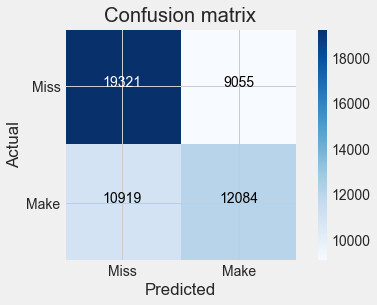

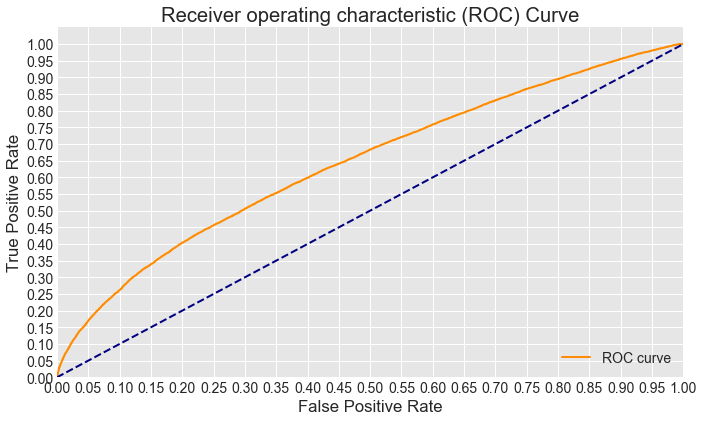

In [65]:
print_model_metrics(log_y_preds, log_y_score)
plot_roc_curve(log_fpr, log_tpr)

# Test Set Metrics:
# Accuracy:   0.6108
# Precision:  0.569
# Recall:     0.5385
# F1          0.5533
# AUC:        0.6464

# Training Set Metrics:
# Accuracy:   0.6092
# Precision:  0.5689
# Recall:     0.538
# F1          0.553
# AUC:        0.6449

# Random Forest Classifier

In [132]:
rf, rf_y_preds, rf_y_score, rf_fpr, rf_tpr, rf_thresholds = build_model(RandomForestClassifier(
                                                                        n_estimators=500, criterion='entropy',
                                                                        max_features='sqrt',min_samples_leaf=10,
                                                                        min_samples_split=10, verbose=1,
                                                                        class_weight='balanced',n_jobs=2,
                                                                        random_state=23),
                                                                        X_train, X_test, y_train, y_test,
                                                                        decision_function=False)


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    4.5s finished


Total Runtime: 164.179584980011 seconds


In [ ]:
# with open('./models/rf/rf_' + str(round(rf.score(X,y),4)).replace('0.','') + '_' + time.asctime().replace(' ', '_'), 'wb') as f:
#     pickle.dump(rf, f)

Accuracy:   0.6588
Precision:  0.6513
Recall:     0.5117
F1          0.5731
AUC:        0.7118


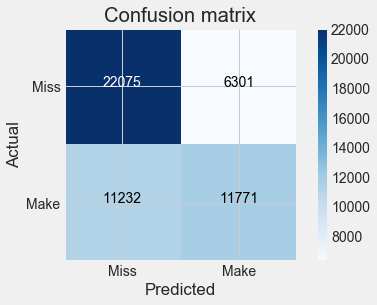

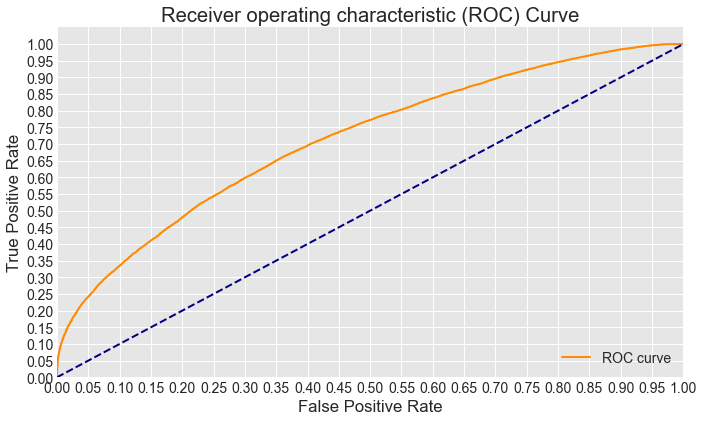

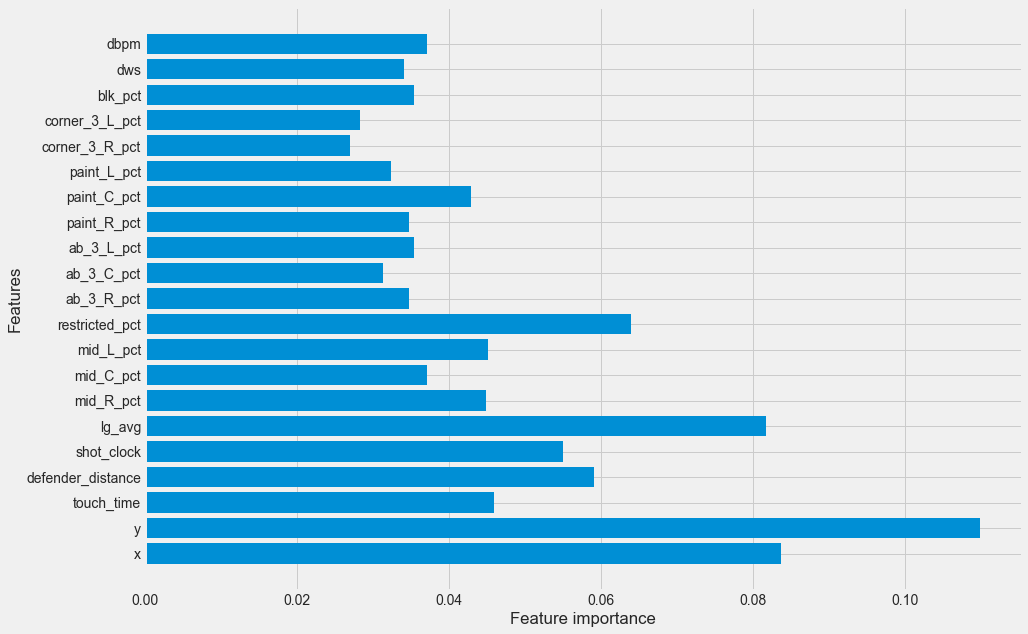

In [133]:
print_model_metrics(rf_y_preds, rf_y_score)
plot_roc_curve(rf_fpr, rf_tpr)
plot_feature_importances(rf)

# Test Set Metrics:
# Accuracy:   0.6559
# Precision:  0.6364
# Recall:     0.5396
# F1          0.584
# AUC:        0.7125

# Training Set Metrics:
# Accuracy:   0.8714
# Precision:  0.8679
# Recall:     0.8419
# F1          0.8547
# AUC:        0.9442

In [120]:
rf_param_grid = {"n_estimators": [50,100,250,500],
                  "min_samples_leaf": [5,10,25],
                  "min_samples_split": [5,10,25],
                  #"criterion": ["gini", "entropy"]
                }


In [121]:
from pactools.grid_search import GridSearchCVProgressBar

start = time.time()

search = GridSearchCVProgressBar(rf, rf_param_grid, scoring='roc_auc', n_jobs=2, verbose=0)

search.fit(X_train,y_train)
    
print("Total Runtime for Grid Search: {:.4} seconds".format(round(time.time() - start, 2)))
print("Testing Accuracy: {:.4}%".format(search.best_score_ * 100))
print("\nOptimal Parameters: {}".format(search.best_params_))
rf_search_results = pd.DataFrame.from_dict(search.cv_results_)
# [........................................] 100% | 4672.27 sec | GridSearchCV 
# Total Runtime for Grid Search: 5.172e+03 seconds
# Testing Accuracy: 70.73%

# Optimal Parameters: {'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 500}

[........................................] 100% | 4672.27 sec | GridSearchCV 
Total Runtime for Grid Search: 5.172e+03 seconds
Testing Accuracy: 70.73%

Optimal Parameters: {'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 500}


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training scor

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,19.377133,1.198613,1.070254,0.114298,5,5,50,"{'min_samples_leaf': 5, 'min_samples_split': 5...",0.693784,0.698171,0.691721,0.694559,0.002689,36,0.991379,0.990983,0.990599,0.990987,0.000319
1,44.949041,5.893380,2.777629,0.117414,5,5,100,"{'min_samples_leaf': 5, 'min_samples_split': 5...",0.701026,0.705374,0.695077,0.700492,0.004220,26,0.992930,0.992752,0.992679,0.992787,0.000105
2,131.093225,2.246564,9.032062,1.242888,5,5,250,"{'min_samples_leaf': 5, 'min_samples_split': 5...",0.703993,0.707896,0.699901,0.703930,0.003264,20,0.993759,0.993707,0.993527,0.993664,0.000100
3,264.572145,13.323018,18.639668,2.303971,5,5,500,"{'min_samples_leaf': 5, 'min_samples_split': 5...",0.706054,0.709750,0.700733,0.705512,0.003701,7,0.994007,0.993889,0.993824,0.993907,0.000076
4,21.116918,1.897002,1.609085,0.327003,5,10,50,"{'min_samples_leaf': 5, 'min_samples_split': 1...",0.694346,0.699197,0.692016,0.695186,0.002991,35,0.991237,0.990969,0.990860,0.991022,0.000159
5,50.039280,4.385495,2.417721,0.286806,5,10,100,"{'min_samples_leaf': 5, 'min_samples_split': 1...",0.700070,0.703773,0.697430,0.700424,0.002602,27,0.992718,0.992689,0.992657,0.992688,0.000025
6,116.312774,4.086191,6.235141,0.621654,5,10,250,"{'min_samples_leaf': 5, 'min_samples_split': 1...",0.704551,0.708373,0.700485,0.704470,0.003221,13,0.993718,0.993615,0.993506,0.993613,0.000086
7,212.783933,2.306879,12.178506,0.711604,5,10,500,"{'min_samples_leaf': 5, 'min_samples_split': 1...",0.705340,0.707975,0.700532,0.704616,0.003081,12,0.994005,0.993926,0.993878,0.993936,0.000053
8,19.108253,3.830056,0.826745,0.043445,5,25,50,"{'min_samples_leaf': 5, 'min_samples_split': 2...",0.696282,0.701639,0.691550,0.696490,0.004121,34,0.960145,0.961230,0.960666,0.960680,0.000443
9,37.875775,3.616335,1.806873,0.136282,5,25,100,"{'min_samples_leaf': 5, 'min_samples_split': 2...",0.702084,0.706444,0.696999,0.701842,0.003860,25,0.964931,0.965007,0.964544,0.964827,0.000203


In [130]:
rf_search_results.to_csv('rf_grid_search_results_926.csv')

# Gradient Boosting Classifier

In [74]:
gb, gb_y_preds, gb_y_score, gb_fpr, gb_tpr, gb_thresholds = build_model(GradientBoostingClassifier(
                                                                        learning_rate=.1, n_estimators=100, 
                                                                        max_depth=5, min_samples_leaf=5,
                                                                        min_samples_split=5, verbose=1, 
                                                                        random_state=23),
                                                                        X_train, X_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.3587            2.03m
         2           1.3447            1.85m
         3           1.3326            1.74m
         4           1.3224            1.68m
         5           1.3138            1.65m
         6           1.3063            1.62m
         7           1.2991            1.59m
         8           1.2934            1.57m
         9           1.2875            1.55m
        10           1.2833            1.54m
        20           1.2551            1.34m
        30           1.2389            1.19m
        40           1.2267            1.02m
        50           1.2195           49.34s
        60           1.2133           38.76s
        70           1.2059           29.60s
        80           1.2006           19.60s
        90           1.1964            9.76s
       100           1.1922            0.00s
Total Runtime: 97.1351580619812 seconds


Accuracy:   0.6615
Precision:  0.6941
Recall:     0.4362
F1          0.5357
AUC:        0.7174


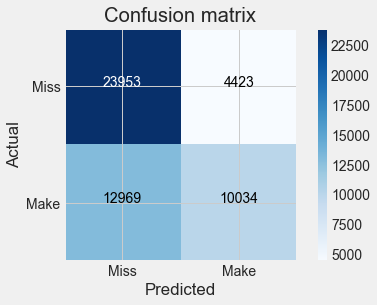

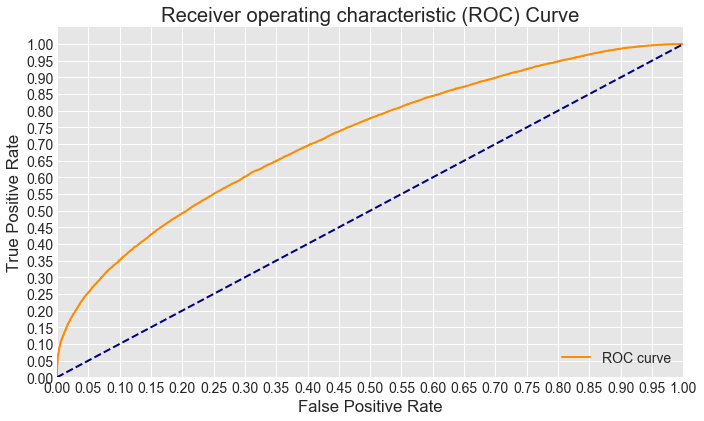

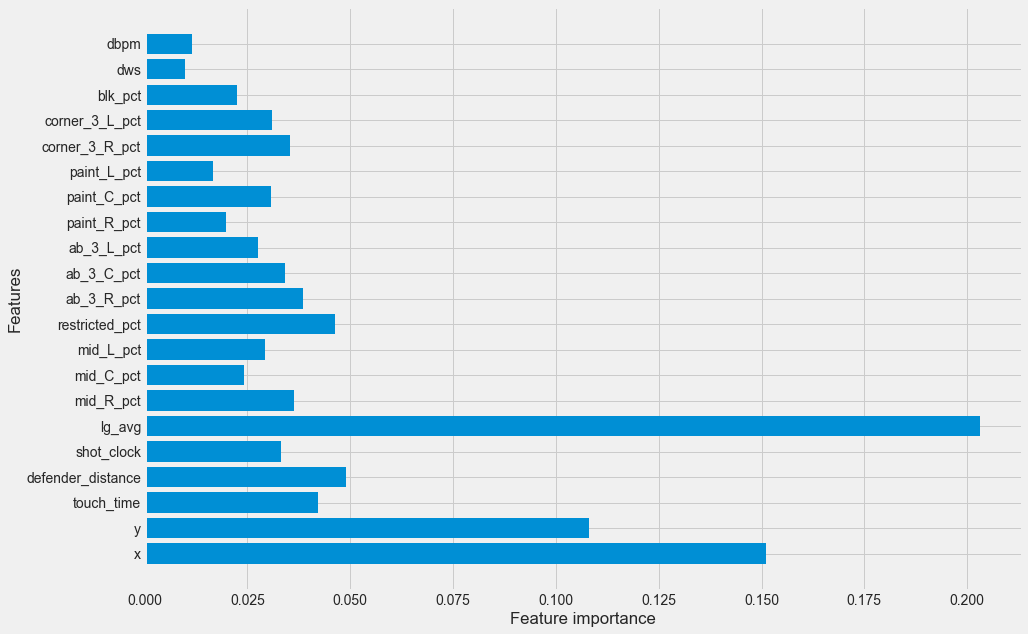

In [76]:
print_model_metrics(gb_y_preds, gb_y_score)
plot_roc_curve(gb_fpr, gb_tpr)
plot_feature_importances(gb)

# Test Set Metrics:
# Accuracy:   0.6605
# Precision:  0.6976
# Recall:     0.4267
# F1          0.5295
# AUC:        0.7169

# Training Set Metrics:
# Accuracy:   0.6696
# Precision:  0.7172
# Recall:     0.4371
# F1          0.5432
# AUC:        0.7356

# AdaBoost Classifier

In [59]:
ada, ada_y_preds, ada_y_score, ada_fpr, ada_tpr, ada_thresholds = build_model(AdaBoostClassifier(
                                                                        learning_rate=1, n_estimators=100, 
                                                                        algorithm='SAMME.R', random_state=23),
                                                                        X_train, X_test, y_train, y_test)

Total Runtime: 26.121104955673218 seconds


Accuracy:   0.6342
Precision:  0.6377
Recall:     0.4236
F1          0.509
AUC:        0.6578


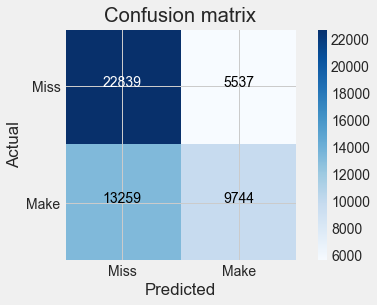

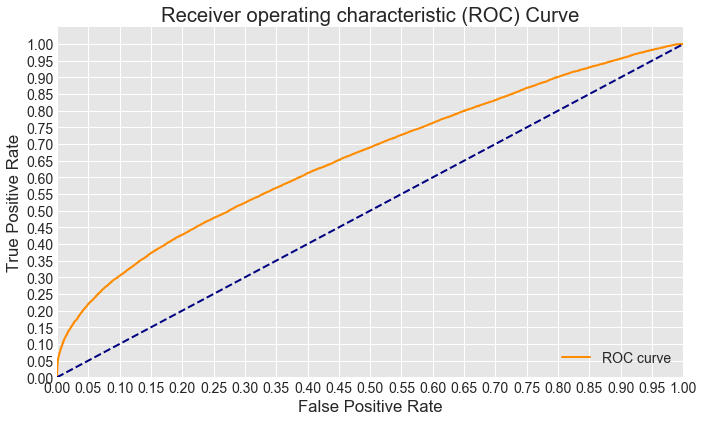

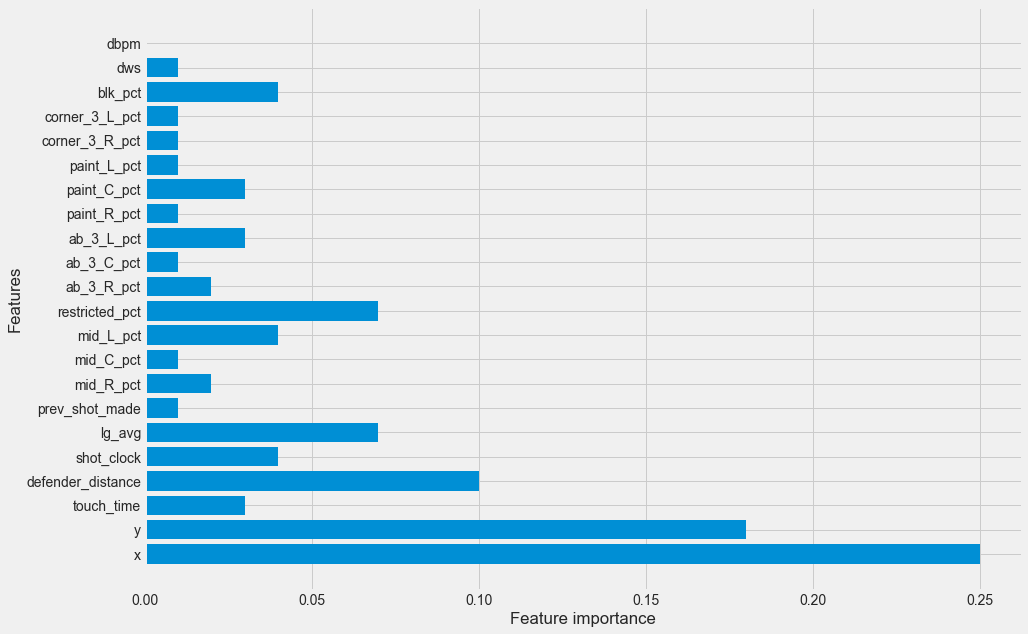

In [60]:
print_model_metrics(ada_y_preds, ada_y_score)
plot_roc_curve(ada_fpr, ada_tpr)
plot_feature_importances(ada)

# Test Set Metrics:
# Accuracy:   0.6377
# Precision:  0.6506
# Recall:     0.4122
# F1          0.5046
# AUC:        0.6623

# Training Set Metrics:
# Accuracy:   0.6347
# Precision:  0.6477
# Recall:     0.4102
# F1          0.5023
# AUC:        0.6632

# XGBoost

In [81]:
xgb = XGBClassifier(n_jobs=2,random_state=23)

xgb.fit(X_train, y_train,verbose=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=23, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [93]:
xgb_y_preds = xgb.predict(X_train)

In [94]:
xgb_y_score = xgb.predict_proba(X_train)[:,1]

Accuracy:   0.6442
Precision:  0.6931
Recall:     0.3738
F1          0.4856
AUC:        0.6938


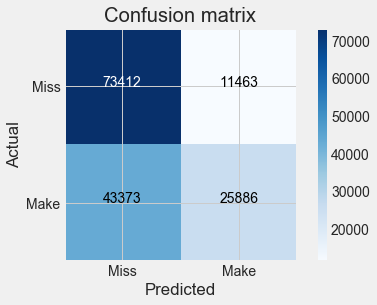

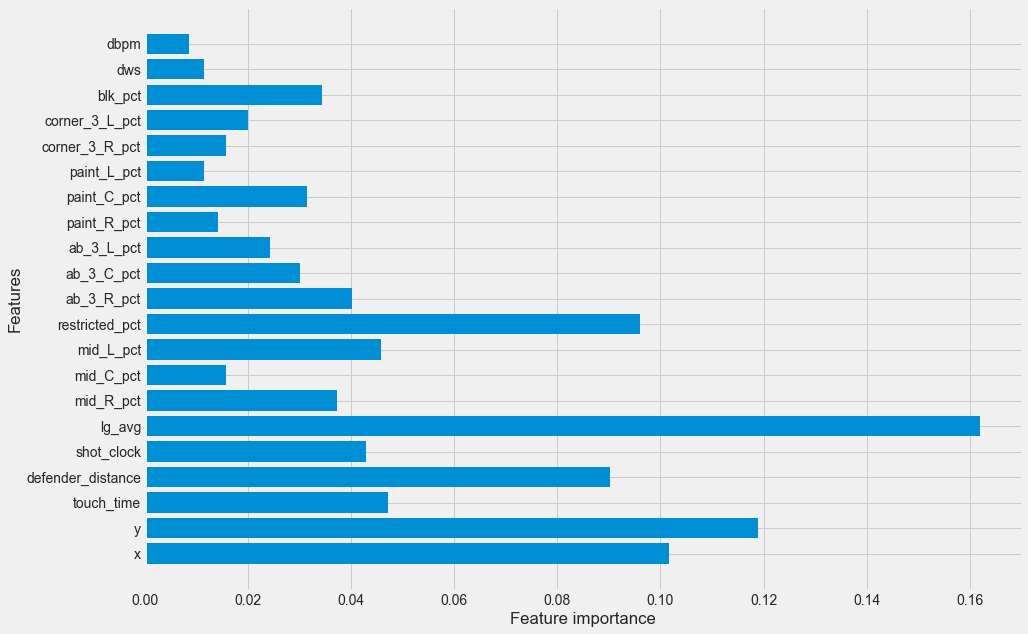

In [98]:
print_model_metrics_train(xgb_y_preds,xgb_y_score)
plot_feature_importances(xgb)

In [97]:
def print_model_metrics_train(y_pred,y_score):
    cm = confusion_matrix(y_train, y_pred)
    #print(cm)
    true_negative, false_positive, false_negative, true_positive = cm[0,0], cm[0,1], cm[0,1], cm[0,1]

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_train,y_pred)
    precision = precision_score(y_train,y_pred)
    recall = recall_score(y_train,y_pred)
    f1 = f1_score(y_train,y_pred)
    fpr, tpr, thresholds = roc_curve(y_train, y_score)
    
    #print('Training Set Metrics:')
    print('Accuracy:   {}'.format(round(accuracy,4)))
    print('Precision:  {}'.format(round(precision,4)))
    print('Recall:     {}'.format(round(recall,4)))
    print('F1          {}'.format(round(f1,4)))
    print('AUC:        {}'.format(round(auc(fpr, tpr),4)))

# PCA

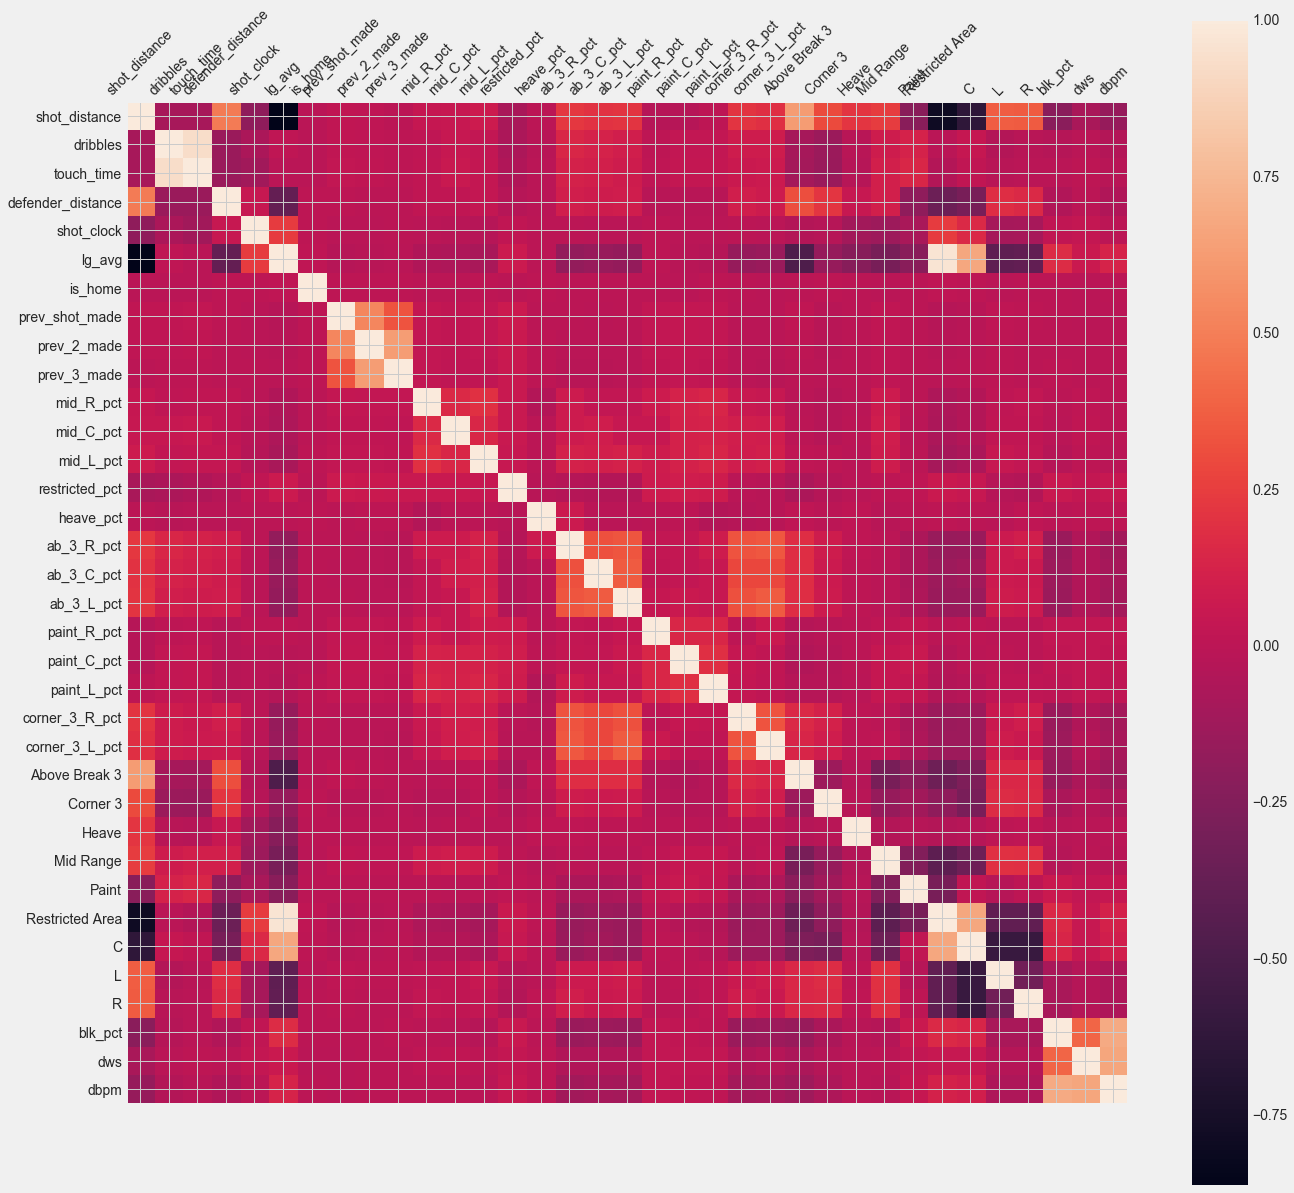

In [89]:
fig, ax = plt.subplots(figsize=(20,20))
mat = ax.matshow(X.corr())
ax.set_xticks(np.arange(0,35,1))
ax.set_yticks(np.arange(0,35,1))
ax.set_xticklabels(X.columns, rotation = 45)
ax.set_yticklabels(X.columns)
fig.colorbar(mat)
plt.show();

In [94]:
X.describe()

,shot_distance,dribbles,touch_time,defender_distance,shot_clock,lg_avg,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R,blk_pct,dws,dbpm
count,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.00000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000,205513.000000
mean,12.360444,1.969121,2.696155,4.091606,11.860579,0.448931,0.499647,0.401337,0.158978,0.070798,0.372864,0.352656,0.361528,0.591150,0.009891,0.261552,0.249898,0.262857,0.358322,0.368881,0.339603,0.280363,0.290395,0.193462,0.070516,0.003406,0.259643,0.149903,0.32307,0.511364,0.244773,0.243863,1.736967,1.844625,0.152427
std,9.915831,3.412921,2.940504,2.790822,6.268984,0.107971,0.500001,0.490170,0.365656,0.256488,0.179519,0.224482,0.178290,0.125187,0.084216,0.209478,0.219762,0.210635,0.244038,0.189093,0.256320,0.257326,0.254780,0.395013,0.256016,0.058263,0.438440,0.356977,0.46765,0.499872,0.429953,0.429412,1.616854,1.165132,1.743879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.022900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.100000,-10.200000
25%,2.000000,0.000000,0.800000,2.200000,7.400000,0.384100,0.000000,0.000000,0.000000,0.000000,0.300000,0.250000,0.285700,0.542900,0.000000,0.000000,0.000000,0.000000,0.200000,0.285700,0.142900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.600000,0.900000,-1.000000
50%,13.000000,0.000000,1.500000,3.600000,12.000000,0.395000,0.000000,0.000000,0.000000,0.000000,0.384600,0.375000,0.379300,0.598100,0.000000,0.300000,0.275900,0.296300,0.363600,0.384600,0.333300,0.306500,0.333300,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.200000,1.700000,0.000000
75%,23.000000,2.000000,3.600000,5.300000,16.400000,0.599900,1.000000,1.000000,0.000000,0.000000,0.459700,0.473700,0.452100,0.648600,0.000000,0.394600,0.395300,0.387100,0.500000,0.470600,0.500000,0.457100,0.444400,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,0.000000,0.000000,2.300000,2.400000,1.200000
max,86.000000,32.000000,24.900000,70.700000,24.000000,0.599900,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,26.300000,5.400000,17.100000


In [128]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(X_std)

In [129]:
X_std.columns = list(X)
X_std.head()

,shot_distance,dribbles,touch_time,defender_distance,shot_clock,lg_avg,is_home,prev_shot_made,prev_2_made,prev_3_made,mid_R_pct,mid_C_pct,mid_L_pct,restricted_pct,heave_pct,ab_3_R_pct,ab_3_C_pct,ab_3_L_pct,paint_R_pct,paint_C_pct,paint_L_pct,corner_3_R_pct,corner_3_L_pct,Above Break 3,Corner 3,Heave,Mid Range,Paint,Restricted Area,C,L,R,blk_pct,dws,dbpm
0,-0.843143,0.595057,0.817496,-0.068656,-1.796241,-0.443001,-0.999295,-0.818773,-0.434775,-0.27603,-2.077020,-1.570982,-2.027752,-4.722152,-0.117448,-1.248588,-1.137136,-1.247929,-1.468306,3.337620,-1.324921,-1.089525,-1.139792,-0.489763,-0.275438,-0.058462,-0.592199,2.381383,-0.690838,0.977524,-0.569302,-0.567901,-0.517653,-0.810748,-1.865058
1,1.375537,-0.576962,-0.610834,1.615440,-0.679630,-0.973699,-0.999295,-0.818773,-0.434775,-0.27603,-0.127362,-1.252916,0.589893,-0.686575,-0.117448,0.155378,1.138062,0.136936,0.239219,-0.127350,-0.154505,-0.657776,0.542451,2.041805,-0.275438,-0.058462,-0.592199,-0.419924,-0.690838,-1.022993,-0.569302,1.760870,-0.517653,-0.810748,-1.865058
2,-0.238049,1.181067,0.919520,0.647981,0.995287,-0.597672,-0.999295,-0.818773,-0.434775,-0.27603,-2.077020,-1.570982,-2.027752,-4.722152,-0.117448,-1.248588,-1.137136,-1.247929,-1.468306,-1.950796,-1.324921,-1.089525,-1.139792,-0.489763,-0.275438,-0.058462,-0.592199,2.381383,-0.690838,-1.022993,-0.569302,1.760870,-0.517653,-0.810748,-1.865058
3,-1.044841,-0.576962,-0.610834,-1.036115,0.181756,1.398233,1.000706,-0.818773,-0.434775,-0.27603,3.493430,-1.570982,-2.027752,0.046730,-0.117448,-1.248588,-1.137136,-1.247929,-0.102532,0.315819,-0.024589,-1.089525,-1.139792,-0.489763,-0.275438,-0.058462,-0.592199,-0.419924,1.447518,0.977524,-0.569302,-0.567901,-0.517653,-0.810748,-1.865058
4,-1.145690,0.595057,0.307378,-1.107779,-1.333645,1.398233,1.000706,1.221340,2.300041,3.62279,0.454750,-0.086225,-0.287329,-0.745687,-0.117448,1.934085,-1.137136,-0.816376,0.580560,-0.253214,0.235633,-1.089525,2.785179,-0.489763,-0.275438,-0.058462,-0.592199,-0.419924,1.447518,0.977524,-0.569302,-0.567901,-0.517653,-0.810748,-1.865058


In [130]:
cov_mat = np.cov(X_std.T)
cov_mat

array([[ 1.00000487, -0.08969623, -0.0866724 , ..., -0.21343731,
        -0.08100218, -0.16065458],
       [-0.08969623,  1.00000487,  0.92854896, ..., -0.03285235,
        -0.0062855 , -0.03597957],
       [-0.0866724 ,  0.92854896,  1.00000487, ..., -0.00543288,
         0.00939708, -0.01665918],
       ...,
       [-0.21343731, -0.03285235, -0.00543288, ...,  1.00000487,
         0.39623154,  0.69234558],
       [-0.08100218, -0.0062855 ,  0.00939708, ...,  0.39623154,
         1.00000487,  0.66710305],
       [-0.16065458, -0.03597957, -0.01665918, ...,  0.69234558,
         0.66710305,  1.00000487]])

In [131]:
eig_values, eig_vectors = np.linalg.eig(cov_mat)

In [132]:
eig_values

In [133]:
eig_vectors

In [134]:
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]
eig_pairs

[(4.967505958039926,
  array([-4.04994771e-01,  6.04291127e-03,  3.18426941e-03, -2.16906653e-01,
          9.79570045e-02,  4.00244039e-01,  5.20555341e-03, -1.20750960e-02,
         -5.99989902e-03, -1.83002932e-03, -3.83156944e-02, -4.75635393e-02,
         -6.76491834e-02,  4.16300839e-02,  2.62653402e-04, -1.63010792e-01,
         -1.45451855e-01, -1.57047245e-01, -2.46325407e-04, -9.83208130e-03,
         -2.11380783e-02, -1.52528948e-01, -1.47246505e-01, -2.32480687e-01,
         -1.28431922e-01, -5.65713654e-02, -1.37457102e-01,  2.55082981e-02,
          3.83128829e-01,  3.50890312e-01, -2.06428562e-01, -2.01777258e-01,
          1.48730554e-01,  7.78414726e-02,  1.27484135e-01])),
 (2.47515145820952,
  array([ 0.12600047, -0.41671943, -0.39737286,  0.15570543, -0.01652397,
         -0.12419706,  0.00245199, -0.02837229, -0.02810958, -0.01681382,
         -0.08620977, -0.12187186, -0.12964604,  0.01125284,  0.0123973 ,
         -0.29445794, -0.27893801, -0.28582649, -0.0713882

In [135]:
sum(np.square(eig_vectors))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

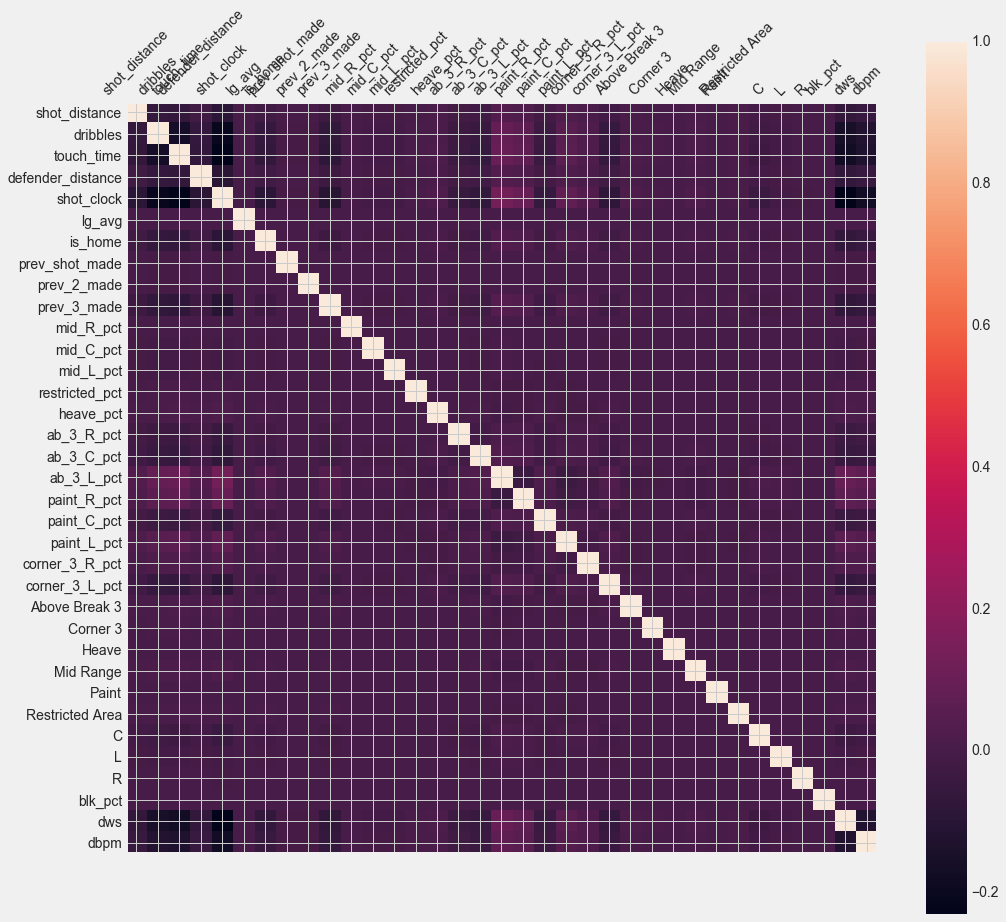

In [136]:
eig_vectors = pd.DataFrame(eig_vectors)
fig, ax = plt.subplots(figsize=(15,15))
mat = ax.matshow(eig_vectors.corr())
ax.set_xticks(np.arange(0,35,1))
ax.set_yticks(np.arange(0,35,1))
ax.set_xticklabels(X.columns, rotation = 45)
ax.set_yticklabels(X.columns)
fig.colorbar(mat)
plt.show();

## Dimensionality reduction with PCA

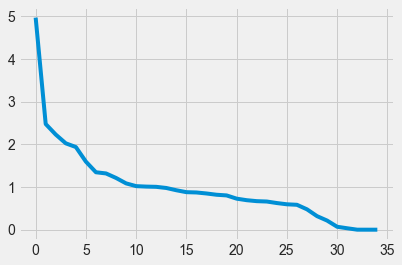

In [137]:
eig_val_sorted = sorted(eig_values,reverse=True)
plt.plot(eig_val_sorted);

In [149]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=35, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [147]:
pca.explained_variance_ # --> should sum to 35

exp_var_ratio = pca.explained_variance_ratio_
exp_var_ratio
cum_variance = exp_var_ratio.cumsum()

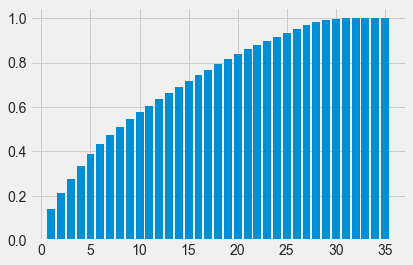

In [148]:
index = np.arange(len(cum_variance))+1
plt.bar(index, cum_variance);

In [179]:
#3 PCs
pca_3 = PCA(n_components=3)
pca_3.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [180]:
eig_values = pca_3.explained_variance_

eig_vectors = pca_3.components_
eig_vectors

array([[ 4.04994746e-01, -6.04295481e-03, -3.18431981e-03,
         2.16906593e-01, -9.79569070e-02, -4.00244034e-01,
        -5.20570276e-03,  1.20749503e-02,  5.99994774e-03,
         1.83017299e-03,  3.83154174e-02,  4.75635127e-02,
         6.76492292e-02, -4.16305509e-02, -2.62586904e-04,
         1.63010808e-01,  1.45451956e-01,  1.57047312e-01,
         2.46183580e-04,  9.83240736e-03,  2.11384366e-02,
         1.52528807e-01,  1.47246432e-01,  2.32480642e-01,
         1.28431989e-01,  5.65713563e-02,  1.37457064e-01,
        -2.55082471e-02, -3.83128831e-01, -3.50890358e-01,
         2.06428550e-01,  2.01777324e-01, -1.48730556e-01,
        -7.78414600e-02, -1.27484129e-01],
       [-1.26008045e-01,  4.16691110e-01,  3.97342878e-01,
        -1.55743555e-01,  1.64815656e-02,  1.24187771e-01,
        -2.83104133e-03,  2.83225079e-02,  2.81210618e-02,
         1.68539060e-02,  8.59816551e-02,  1.21717727e-01,
         1.29543015e-01, -1.12985722e-02, -1.24197200e-02,
         2.94

In [181]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]

In [182]:
PC_df = pd.DataFrame(pca_3.transform(X_std), index=X.index, columns=['PC1','PC2','PC3'])

In [195]:
PC_df.head()

,PC1,PC2,PC3
0,-1.233696,-0.687910,-0.714104
1,3.157503,-0.535853,-2.111817
2,0.071255,-1.534470,-1.385745
3,-3.189508,-0.770160,-1.943062
4,-1.789764,2.578261,0.208127


In [198]:
from sklearn.cluster import KMeans

In [199]:
k_means = KMeans(n_clusters=5)

k_means.fit(PC_df)

y_hat_pc = k_means.predict(PC_df)

In [209]:
cl_centers = k_means.cluster_centers_
cl_centers[:,0]

array([ 2.23219337, -2.09924519,  0.04697082,  1.14499226, -3.32742859])

## Multi indexing


In [177]:
multi_df = df.set_index(['name','game_date','game_event_id']).sort_index()
multi_df_X = multi_df.drop(columns=['age','pos','player_id','team_id','opp_id','team_name','opponent',
                     'defender_name','game_id','action_type','season','htm', 'vtm',
                     'minutes_remaining','seconds_remaining','defender_id','shot_type',
                     'x','y', 'shot_made_flag'])
multi_df_y = multi_df.shot_made_flag

In [178]:
multi_df_X

shot_distance  dribbles  touch_time  \
name         game_date  game_event_id                                        
AJ Price     2014-11-07 102                       19         3         2.9   
                        126                        7         3         1.9   
                        326                        9        17        13.5   
                        328                       25         7         6.1   
                        368                        9        12        10.0   
                        372                       24         1         0.9   
                        378                       24        14        12.1   
             2014-11-08 117                       17        11         9.8   
                        123                       15        23        18.6   
                        182                       11        10         9.4   
                        205                       14        13        10.5   
                        348                        3         5         3.7   
                        374                       16        27        21.8   
                        406                       17        18        14.4   
                        426                       26         2         4.9   
             2014-11-10 116                       28         1         1.7   
                        149                        8        12         7.6   
                        171                       17        13        10.0   
                        206                        6        11         8.6   
                        217                       13        13        11.4   
                        357                       25        14        10.2   
                        382                       19         4         4.3   
                        388                       20         2         2.2   
                        394                       27         0         1.1   
                        418                       25         0         1.0   
                        466                       14         0         0.0   
                        480                       20         1         1.5   
             2014-11-12 96                        13         1         2.2   
                        98                        25         0         0.9   
                        105                       24         0         0.9   
...                                              ...       ...         ...   
Zoran Dragic 2014-11-15 646                       27         0         1.5   
             2015-01-02 501                       23         0         1.0   
                        535                        2         0         1.4   
                        538                        1         0         0.9   
             2015-01-25 551                       24         0         1.9   
             2015-01-31 523                       26         2        13.6   
             2015-02-05 513                       23         0         0.9   
                        522                        0         2         2.6   
             2015-03-27 492                        0         1         1.5   
                        505                       20         1         2.4   
             2015-04-02 548                       16         0         1.0   
                        551                       25         0         0.8   
             2015-04-05 541                       25         0         1.1   
             2015-04-15 9                         23         0         1.0   
                        17                        23         0         1.0   
                        34                         0         5         5.4   
                        57                        23         0         0.8   
                        99                         0         1         1.3   
                        132                       26         